# Clasificador paisajes
Para este ejercicio vas a crear un clasificador automático de paisajes. Los datos los encontrarás en el Classroom como `seg_train.zip` y `seg_test.zip`. Se pide:
1. Cargar las imágenes. Mira cómo están almacenados los datos. Tendrás que recorrer las carpetas, cargar las imágenes en memoria y etiquetarlas con los nombres de las carpetas. Realiza un reshape de cada imagen (comienza el ejercicio con 32x32, para ir más rápido en las ejecuciones).
2. Investiga las imágenes, comprueba con algunas muestras que has cargado bien los datos.
3. Normaliza
4. Diseña la arquitectura de la red. Recuerda que es un algiritmo de clasificación. Ojo con las dimensiones de la entrada
5. Reserva un 20% de los datos del entrenamiento para validar.
6. Representa el objeto history
7. Evalua el modelo con los datos de test
8. Representa algunos de los paisajes donde el modelo comete errores
9. Crea una matriz de confusión con los errores del modelo

**NOTA apartado 1**: para el apartado 1 tendras que recorre las carpetas/imagenes con `os.listdir()`, e ir cargando todas las imagenes como arrays de numpy

**NOTA apartado 4**: empieza con un par de capas Conv2D + MaxPooling2D con activación relu y después la fully connected layer. on softmax como ultima capa

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [3]:
class_names = ['mountain','street','glacier', 'buildings','sea','forest']

IMAGE_SIZE = (32,32)

In [4]:
class_names_label = {class_name:i for i ,class_name in enumerate(class_names)}
class_names_label

{'mountain': 0,
 'street': 1,
 'glacier': 2,
 'buildings': 3,
 'sea': 4,
 'forest': 5}

In [5]:
ROOT_PATH = os.getcwd()

TRAIN_PATH = ROOT_PATH + "\\data_paisajes\\seg_train\\"
TEST_PATH = ROOT_PATH + "\\data_paisajes\\seg_test\\"

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ruta correcta
TRAIN_DIR = os.path.join(ROOT_PATH, "data_paisajes", "seg_train", "seg_train")
TEST_DIR = os.path.join(ROOT_PATH, "data_paisajes", "seg_test", "seg_test")

# Generador con reescalado de imágenes
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(31, 31),  # puedes cambiar tamaño
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(31, 31),
    batch_size=32,
    class_mode='categorical'
)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [7]:
print(train_generator.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


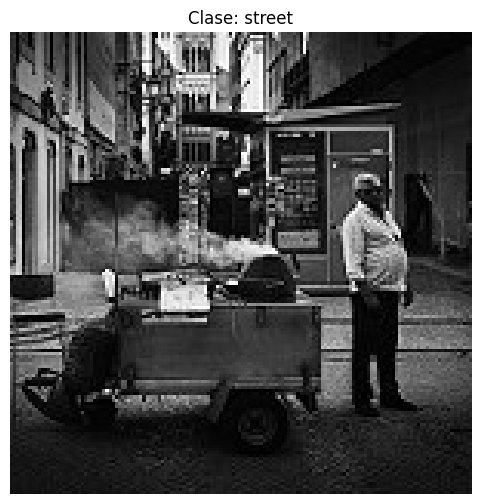

In [8]:
import random
from skimage.io import imread

TRAIN_PATH = os.path.join(ROOT_PATH, "data_paisajes", "seg_train", "seg_train")

classes = os.listdir(TRAIN_PATH)
random_class = random.choice(classes)

class_path = os.path.join(TRAIN_PATH, random_class)
image_name = random.choice(os.listdir(class_path))

image_path = os.path.join(class_path, image_name)

image = imread(image_path)

plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Clase: {random_class}")
plt.show()


In [9]:
def read_data(path, im_size):
    X = []
    Y = []
    class_names = os.listdir(path)
    class_names.sort()

    label_map = {class_name: idx for idx, class_name in enumerate(class_names)}
    print("Clases encontradas:", label_map)

    for class_name in class_names:
        class_path = os.path.join(path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                image = imread(img_path)
                image = cv2.resize(image, (im_size, im_size))
                X.append(image)
                Y.append(label_map[class_name])
            except:
                print(f"Error cargando: {img_path}")

    return np.array(X), np.array(Y), label_map

In [10]:
IMAGE_WIDTH = 32
X_train, y_train, label_map = read_data(TRAIN_DIR, IMAGE_WIDTH)
X_test, y_test, _ = read_data(TEST_DIR, IMAGE_WIDTH)

Clases encontradas: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Clases encontradas: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


(32, 32, 3)


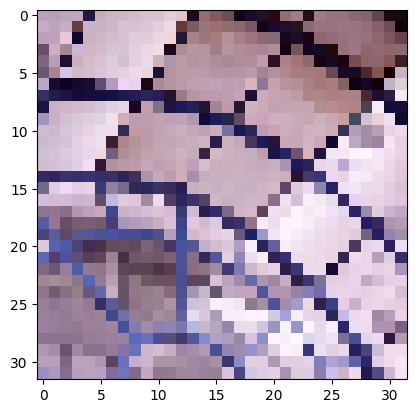

In [11]:
print(X_train[3].shape)
plt.imshow(X_train[3]);

In [12]:
X_train[1]

array([[[ 75, 121, 181],
        [ 71, 121, 184],
        [ 69, 120, 182],
        ...,
        [238, 239, 244],
        [243, 244, 249],
        [237, 238, 244]],

       [[ 85, 130, 187],
        [ 91, 133, 189],
        [ 75, 122, 181],
        ...,
        [230, 230, 238],
        [232, 233, 238],
        [233, 233, 240]],

       [[ 99, 136, 189],
        [164, 185, 224],
        [146, 175, 215],
        ...,
        [226, 229, 239],
        [229, 232, 240],
        [233, 236, 240]],

       ...,

       [[151, 133, 122],
        [158, 145, 128],
        [144, 136, 115],
        ...,
        [104,  83,  74],
        [177, 149, 130],
        [183, 144, 110]],

       [[108, 103,  85],
        [ 40,  41,  23],
        [ 47,  43,  31],
        ...,
        [ 75,  61,  51],
        [ 89,  78,  68],
        [ 24,  10,   7]],

       [[ 40,  43,  22],
        [ 40,  41,  25],
        [ 97,  95,  83],
        ...,
        [ 28,  11,   4],
        [ 50,  33,  24],
        [ 60,  45,  32]]

In [13]:
print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0
Max: 255


In [14]:
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0.0
Max: 1.0


In [15]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [16]:
np.savez(ROOT_PATH + '/data_paisajes.npz',
        X_train = X_train,
        y_train = y_train,
        X_test = X_test,
        y_test = y_test)

In [17]:
data = np.load(ROOT_PATH + '\\data_paisajes.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,         # 20% para validación
    stratify=y_train,      # para mantener la proporción de clases (muy recomendable)
    random_state=42        # reproducibilidad
)


In [19]:
from tensorflow import keras
from tensorflow.keras import layers

In [20]:

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_WIDTH, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(6, activation='softmax')
])

c:\Users\Abdon.RAMIREZ-BRICEN\Documents\DeepLearning - Copy\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,206 (1.20 MB)

 Trainable params: 315,206 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5)

In [24]:
from keras.callbacks import ModelCheckpoint
mcheckpoint = ModelCheckpoint("callback_model.h5")

In [25]:
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    callbacks=[earlystop, mcheckpoint],
    validation_data=(X_val, y_val)
)

Epoch 1/15
349/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4034 - loss: 1.4359

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4042 - loss: 1.4344 - val_accuracy: 0.6174 - val_loss: 0.9827
Epoch 2/15
349/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6003 - loss: 1.0257

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6005 - loss: 1.0253 - val_accuracy: 0.7086 - val_loss: 0.8271
Epoch 3/15
349/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6740 - loss: 0.8798

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6741 - loss: 0.8796 - val_accuracy: 0.7289 - val_loss: 0.7490
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7247 - loss: 0.7735

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7247 - loss: 0.7735 - val_accuracy: 0.7442 - val_loss: 0.7003
Epoch 5/15
346/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7476 - loss: 0.7064

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7476 - loss: 0.7066 - val_accuracy: 0.6897 - val_loss: 0.8075
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7633 - loss: 0.6657

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7633 - loss: 0.6657 - val_accuracy: 0.7581 - val_loss: 0.6605
Epoch 7/15
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7826 - loss: 0.6234

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7826 - loss: 0.6234 - val_accuracy: 0.7681 - val_loss: 0.6426
Epoch 8/15
348/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8004 - loss: 0.5680

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8004 - loss: 0.5681 - val_accuracy: 0.7734 - val_loss: 0.6181
Epoch 9/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8123 - loss: 0.5168

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8122 - loss: 0.5168 - val_accuracy: 0.7570 - val_loss: 0.6713
Epoch 10/15
346/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8159 - loss: 0.5015

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8160 - loss: 0.5015 - val_accuracy: 0.7695 - val_loss: 0.6203
Epoch 11/15
349/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8364 - loss: 0.4525

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8364 - loss: 0.4526 - val_accuracy: 0.7887 - val_loss: 0.6100
Epoch 12/15
346/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8521 - loss: 0.4173

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8520 - loss: 0.4175 - val_accuracy: 0.7773 - val_loss: 0.6603
Epoch 13/15
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8582 - loss: 0.3892

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8582 - loss: 0.3893 - val_accuracy: 0.7795 - val_loss: 0.6660
Epoch 14/15
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8717 - loss: 0.3650

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8717 - loss: 0.3651 - val_accuracy: 0.7905 - val_loss: 0.6457
Epoch 15/15
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8844 - loss: 0.3290

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8844 - loss: 0.3291 - val_accuracy: 0.7859 - val_loss: 0.6854


In [26]:
results = model.evaluate(X_test, y_test)
results

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7902 - loss: 0.6880


[0.7171463966369629, 0.7743333578109741]

In [27]:
model.predict(X_test).round(0)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

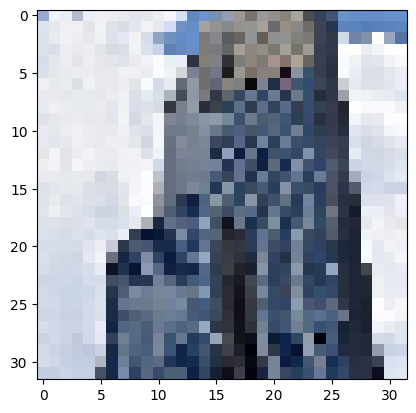

In [28]:
plt.imshow(X_test[0]);

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Total errores: 677


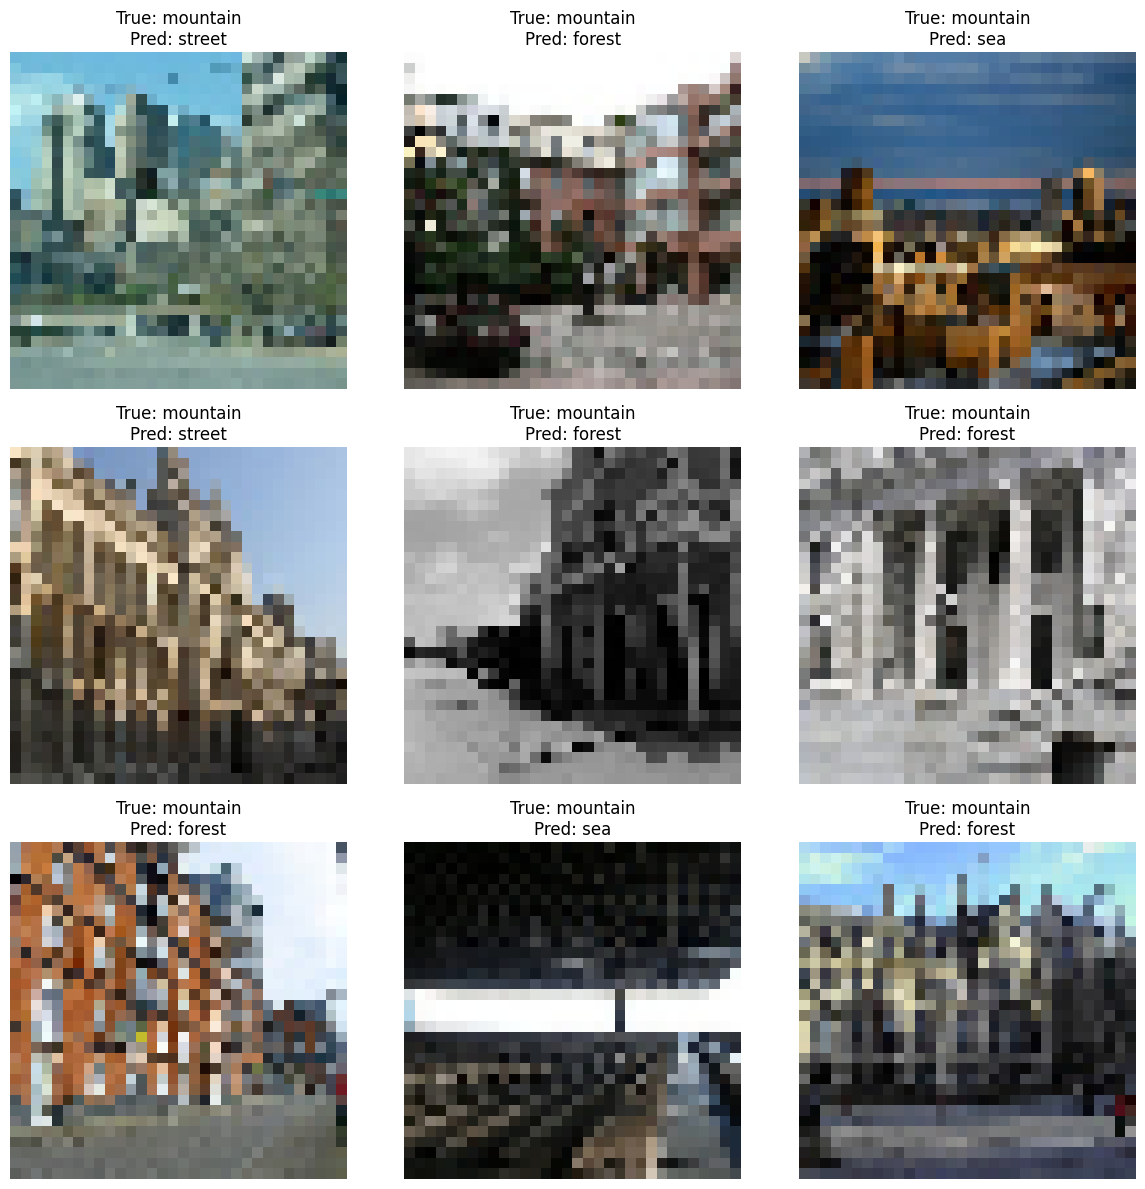

In [29]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

incorrect_idxs = np.where(y_pred != y_test)[0]

print(f"Total errores: {len(incorrect_idxs)}")

plt.figure(figsize=(12, 12))

for i, idx in enumerate(incorrect_idxs[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[idx])
    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_pred[idx]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = np.argmax(y_test, axis=1) if y_test.ndim == 2 else y_test

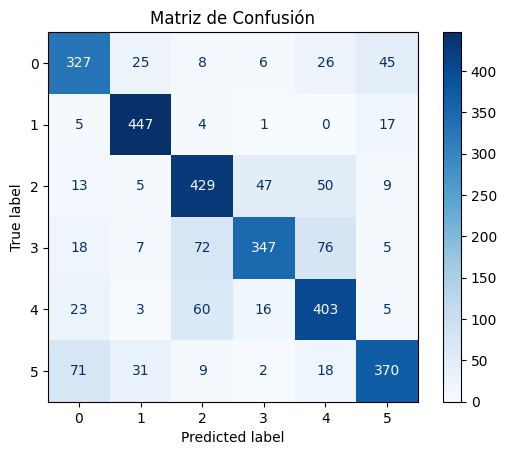

In [31]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()
